In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize # from scipy.misc import imresize
from tqdm import tqdm
import nibabel

In [4]:
def read_train_exam(exam_nb):
    image = nibabel.load('../chaos/train/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    mask = nibabel.load('../chaos/train/%02d-T2SPIR-mask.nii.gz'%(exam_nb))
    return image, mask

def read_test_exam(exam_nb):
    image = nibabel.load('../chaos/test/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    return image


In [5]:
img_rows,img_cols = 256,256
def preprocess(image):
    #shape (slide,256,256)
    image_ = np.ndarray((image.shape[2],img_rows,img_cols,1))
    for i in range(image.shape[2]):
        image_[i,:,:,0] = resize(image.get_data()[:,:,i],(img_rows,img_cols),mode='reflect',preserve_range=True,
                               anti_aliasing=True)            
    #print(image_.shape)
    return image_

In [6]:
image_1, mask_1 = read_train_exam(2)


In [13]:
print("before scale {},{},".format(np.unique(mask_1.get_data()),np.unique(image_1.get_data())))

before scale [0 1 2 3 4],[   0    1    2 ... 1474 1501 1503],


In [14]:
print("after scale {},{}".format(np.unique(preprocess(mask_1)),np.unique(preprocess(image_1))))

after scale [0.       0.015625 0.015625 ... 3.984375 3.984375 4.      ],[0.00000000e+00 1.56250000e-02 1.56250000e-02 ... 1.45790625e+03
 1.46843750e+03 1.48428125e+03]


In [43]:
def mask_to_channels(mask,init,classes):
    #get mask for each class
    img = np.asarray([np.where(mask == i,1,0 ) for i in range(init,classes)])
    img = np.swapaxes(img,0,-1)#new shape (row,col,class)
    print(img.shape)
    return img

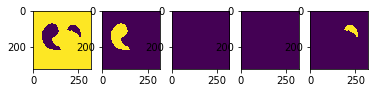

In [34]:
test = mask_1.get_data()[:,:,15]
img = mask_to_channels(test,0,5)
for i in range(0,5):
    plt.subplot(1,5,i+1)
    plt.imshow(img[:,:,i])
plt.show()

In [68]:
def create_data_train(train_ids = [1,2,3,5,8,10,13,19],background = 0):
    for idx, train_id in tqdm(enumerate(train_ids)):
        image, mask = read_train_exam(train_id)     
        image = preprocess(image)
        mask = preprocess(mask) 
        #transform le mask
        if background:
            #create mask for 5 classess
            mask = mask_to_channels(mask,0,5)[0]
        else:
            mask = mask_to_channels(mask,1,5)[0]            
       
        if idx > 0:
            train_data = np.concatenate((train_data, image),axis=0)
            train_mask = np.concatenate((train_mask, mask),axis=0)
        else:
            train_data = image
            train_mask = mask
    print("Final shape {},{}".format(train_data.shape,train_mask.shape))    
    np.savez_compressed('./dataset/imgs_train_{}'.format(background), imgs=train_data)
    np.savez_compressed('./dataset/imgs_mask_train_{}'.format(background), imgs_mask=train_mask)

In [46]:
#dataset training without background
create_data_train()

1it [00:00,  3.35it/s]

(1, 36, 256, 256, 4)


2it [00:00,  3.18it/s]

(1, 26, 256, 256, 4)


3it [00:01,  2.44it/s]

(1, 30, 256, 256, 4)


4it [00:01,  2.46it/s]

(1, 30, 256, 256, 4)


5it [00:02,  2.29it/s]

(1, 32, 256, 256, 4)
(1, 36, 256, 256, 4)


6it [00:02,  2.14it/s]

(1, 30, 256, 256, 4)


7it [00:03,  1.94it/s]

(1, 30, 256, 256, 4)


8it [00:04,  1.71it/s]


Final shape (250, 256, 256, 1),(250, 256, 256, 4)


In [48]:
#dataset training without background
create_data_train(background=1)

1it [00:00,  3.06it/s]

(1, 36, 256, 256, 5)


2it [00:00,  2.92it/s]

(1, 26, 256, 256, 5)


3it [00:01,  2.61it/s]

(1, 30, 256, 256, 5)


4it [00:01,  2.50it/s]

(1, 30, 256, 256, 5)
(1, 32, 256, 256, 5)


5it [00:02,  2.23it/s]

(1, 36, 256, 256, 5)


6it [00:02,  2.03it/s]

(1, 30, 256, 256, 5)


7it [00:03,  1.84it/s]

(1, 30, 256, 256, 5)


8it [00:04,  1.68it/s]


Final shape (250, 256, 256, 1),(250, 256, 256, 5)


### plot images

In [52]:
img = np.load('./dataset/imgs_train_0.npz')['imgs']
img_mask = np.load('./dataset/imgs_mask_train_0.npz')['imgs_mask']

In [53]:
img[:,:,:].shape

(250, 256, 256, 1)

In [54]:
img[:,:,:,0].shape

(250, 256, 256)

In [58]:
#plot random samples from data
def plot_random_images(data,mask,size,id):
    index = np.random.choice(range(data.shape[0]),size)
    plt.figure(figsize=(20, 15))
    for i,x in enumerate(index):
        plt.subplot(1, len(index), i+1)
        plt.imshow(data[x,:,:,0], cmap='gray', interpolation='nearest')
        plt.imshow(mask[x,:,:,id], cmap='jet', alpha=0.5)
    plt.show()

Training data


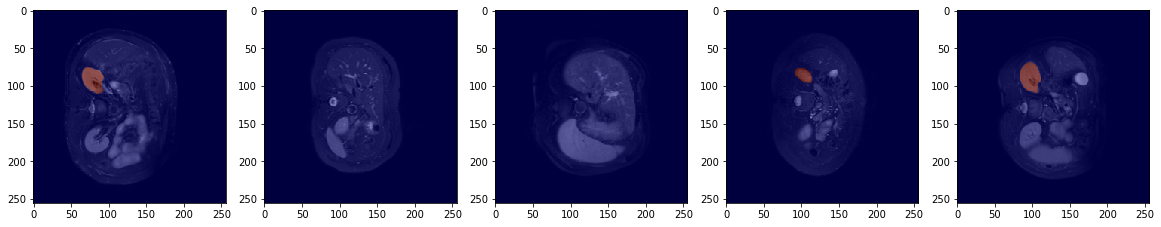

In [59]:
#plot random samples from training data
print("Training data")
plot_random_images(img,img_mask,5,1)

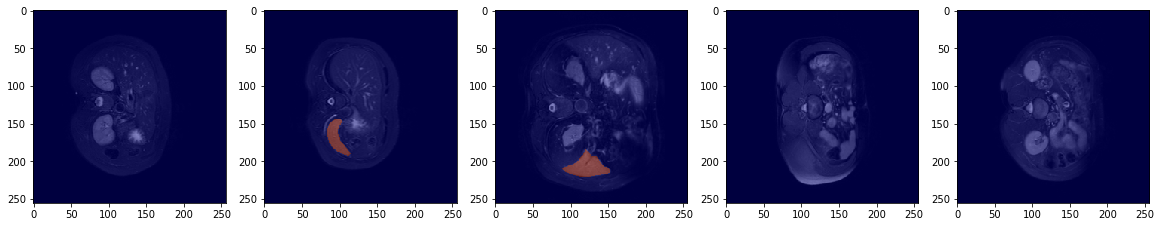

In [62]:
plot_random_images(img,img_mask,5,3)

In [66]:
print(np.unique(img))

[0.00000000e+00 1.00974196e-28 1.51461294e-28 ... 2.02000000e+03
 2.04100000e+03 2.04300000e+03]


In [64]:
imgs_train = img.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

In [67]:
print(np.unique(imgs_train))

[-0.53052306 -0.53049946 -0.53047585 ... 11.664149   11.790925
 11.8029995 ]


### test

In [69]:
def get_data_test(test_ids = [21,22,32,39]):
    for idx, test_id in tqdm(enumerate(test_ids)):
        image = read_test_exam(test_id)     
        image = preprocess(image)
        print("img {}".format(image.shape))
        if idx > 0:
            test_data = np.concatenate((test_data, image),axis=0)
        else:
            test_data = image
    print("Final shape {}".format(test_data.shape))    
    np.savez_compressed('./dataset/imgs_test', imgs=test_data)

In [70]:
get_data_test()

2it [00:00,  8.78it/s]

img (31, 256, 256, 1)
img (33, 256, 256, 1)


4it [00:00,  8.10it/s]

img (39, 256, 256, 1)
img (26, 256, 256, 1)
Final shape (129, 256, 256, 1)


# MODEL

In [2]:
#version tf1
from keras.models import Model
from keras.layers import Input, concatenate,Conv2D, MaxPooling2D, Conv2DTranspose,Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K


from data import load_train_data, load_test_data

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

Using TensorFlow backend.


In [3]:
img_rows = 256
img_cols = 256

In [1]:
smooth = 1.
#batch 32!
def dice_coef_(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef(y_true, y_pred):
    dice_liver = dice_coef_(y_true[0,:,:,0],y_pred[0,:,:,0])
    dice_rkidney = dice_coef_(y_true[0,:,:,1], y_pred[0,:,:,1])
    dice_lkidney = dice_coef_(y_true[0,:,:,2], y_pred[0,:,:,2])
    dice_spleen = dice_coef_(y_true[0,:,:,3], y_pred[0,:,:,3])
    #return dice_liver + (dice_rkidney+dice_lkidney)+dice_spleen
    return dice_liver + 10*dice_rkidney + 10*dice_lkidney +5*dice_spleen
def dice_coef_loss(y_true, y_pred):  
    return -dice_coef_(y_true, y_pred)


In [5]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Conv2D(4, (3,3), activation='relu', padding='same')(conv9)
    
    conv10 = Conv2D(4, (1,1), activation='softmax')(conv9)
    loss_function = 'categorical_crossentropy'
    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(lr=1e-4), loss=loss_function, metrics=[dice_coef_])
    model.summary()
    return model


In [6]:
from data import load_train_data, load_test_data

# training

In [7]:
print('Loading and preprocessing train data...')
print('-'*30)
imgs_train, imgs_mask_train = load_train_data()
name = 'model_softmax.h5'

checkpoint = ModelCheckpoint(name, verbose=1, save_best_only=True, save_weights_only=True)
model = get_unet()

imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization
imgs_train -= mean
imgs_train /= std
print("normalize")
np.savez_compressed('scaler',mean=mean,std=std)

results = model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=100, callbacks=[checkpoint]
                   ,shuffle=True,
              validation_split=0.2)

Loading and preprocessing train data...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
______________________________________

Epoch 4/100
200/200 [==============================] - 4s 19ms/step - loss: 0.0591 - dice_coef_: 0.0253 - val_loss: 0.0495 - val_dice_coef_: 0.0284

Epoch 00004: val_loss improved from 0.05476 to 0.04954, saving model to model_softmax.h5
Epoch 5/100
200/200 [==============================] - 4s 19ms/step - loss: 0.0568 - dice_coef_: 0.0308 - val_loss: 0.0445 - val_dice_coef_: 0.0373

Epoch 00005: val_loss improved from 0.04954 to 0.04449, saving model to model_softmax.h5
Epoch 6/100
200/200 [==============================] - 4s 19ms/step - loss: 0.0552 - dice_coef_: 0.0354 - val_loss: 0.0424 - val_dice_coef_: 0.0365

Epoch 00006: val_loss improved from 0.04449 to 0.04241, saving model to model_softmax.h5
Epoch 7/100
200/200 [==============================] - 4s 19ms/step - loss: 0.0505 - dice_coef_: 0.0374 - val_loss: 0.0309 - val_dice_coef_: 0.0541

Epoch 00007: val_loss improved from 0.04241 to 0.03095, saving model to model_softmax.h5
Epoch 8/100
200/200 [===========================

200/200 [==============================] - 4s 20ms/step - loss: 0.0110 - dice_coef_: 0.0768 - val_loss: 0.0087 - val_dice_coef_: 0.0748

Epoch 00079: val_loss did not improve from 0.00808
Epoch 80/100
200/200 [==============================] - 4s 20ms/step - loss: 0.0110 - dice_coef_: 0.0767 - val_loss: 0.0083 - val_dice_coef_: 0.0749

Epoch 00080: val_loss did not improve from 0.00808
Epoch 81/100
200/200 [==============================] - 4s 20ms/step - loss: 0.0110 - dice_coef_: 0.0767 - val_loss: 0.0088 - val_dice_coef_: 0.0749

Epoch 00081: val_loss did not improve from 0.00808
Epoch 82/100
200/200 [==============================] - 4s 20ms/step - loss: 0.0110 - dice_coef_: 0.0768 - val_loss: 0.0086 - val_dice_coef_: 0.0748

Epoch 00082: val_loss did not improve from 0.00808
Epoch 83/100
200/200 [==============================] - 4s 19ms/step - loss: 0.0110 - dice_coef_: 0.0767 - val_loss: 0.0085 - val_dice_coef_: 0.0750

Epoch 00083: val_loss did not improve from 0.00808
Epoch 84

## name = 'model_softmax.h5'

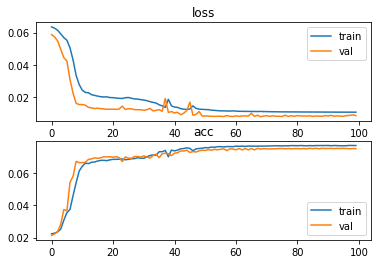

In [8]:
plt.subplot(211)
plt.plot(results.history['loss'], label='train')
plt.plot(results.history['val_loss'], label='val')
plt.title('loss')
plt.legend()

plt.subplot(212)
plt.plot(results.history['dice_coef_'], label='train')
plt.plot(results.history['val_dice_coef_'], label='val')
plt.title('acc')
plt.legend()

# evaluation

In [9]:
name

'model_softmax.h5'

In [54]:
imgs_train, imgs_mask_train = load_train_data()

In [33]:
model = get_unet()
model.load_weights(name)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 256, 256, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_41[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_42[0][0]                  
__________________________________________________________________________________________________
conv2d_43 

In [69]:
id = 190


test = imgs_train[id,:,:,:]
test -= mean
test /= std
y_pred = model.predict(test.reshape(1,256,256,1))

# results

8.8219085e-06 1.0
2.7946756e-18 0.25867796
1.2664942e-21 0.25472263
2.0169212e-23 0.9999379


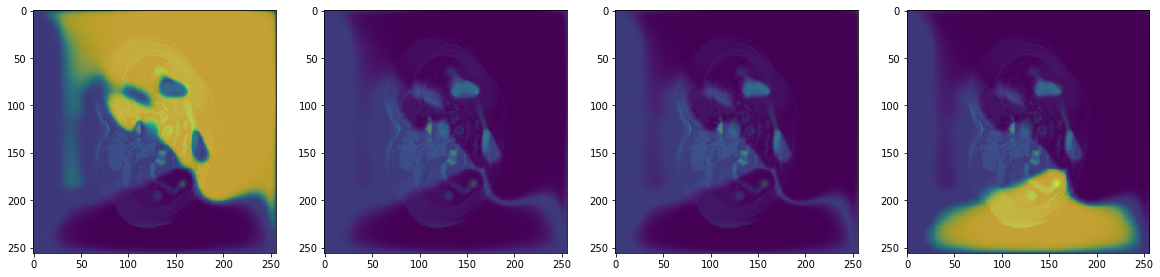

In [70]:
plt.figure(figsize=(20, 15))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(imgs_train[id,:,:,0])
    slice_ = y_pred[0,:,:,i]
    x = np.sum(y_pred, axis = 3)[0]
    print(slice_.min(), slice_.max())
    m = slice_.mean()
    plt.imshow(slice_,vmin=0,vmax=1, alpha=0.7)
plt.show()

# real

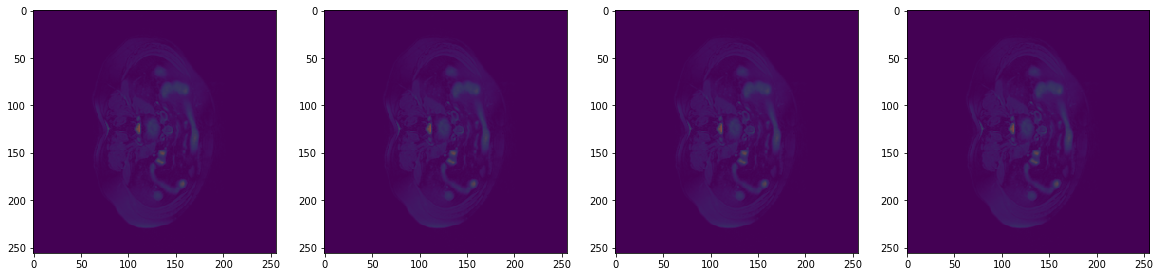

In [71]:
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(1,4,i+1)
    slice_ = imgs_mask_train[id,:,:,i]
    plt.imshow(imgs_train[id,:,:,0])
    plt.imshow(slice_, alpha=0.7)    
plt.show()

# image test

In [206]:
imgs_test = load_test_data()
imgs_test -= mean
imgs_test /= std

In [207]:
mask_predicts = model.predict(imgs_test)

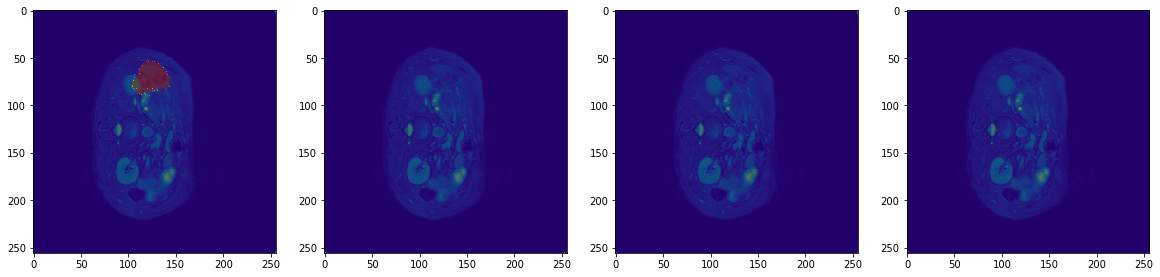

In [209]:
idx = 10
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(imgs_test[idx,:,:,0])
    slice_ = mask_predicts[idx,:,:,i]
    plt.imshow(slice_,vmin = slice_.min(), vmax= slice_.max(),cmap='jet', alpha=0.5)
plt.show()

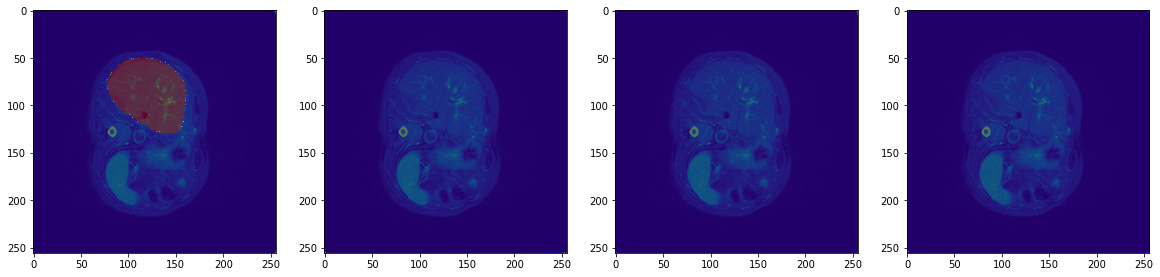

In [211]:
idx = 20
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(imgs_test[idx,:,:,0])
    slice_ = mask_predicts[idx,:,:,i]
    plt.imshow(slice_,vmin = slice_.min(), vmax= slice_.max(),cmap='jet', alpha=0.5)
plt.show()

=======
# 2. dropout and pooling

https://github.com/hlamba28/UNET-TGS/blob/master/TGS%20UNET.ipynb

> of “training hard enough”.

> When training a deep neural network, our biggest concern is nearly always overfitting — and in order to combat overfitting, we introduce regularization techniques (discussed in Reason #1 above). We apply regularization in the form of:

    Dropout
    L2 weight decay
    Reducing model capacity (i.e., a more shallow model)

>We also tend to be a bit more conservative with our learning rate to ensure our model doesn’t overshoot areas of lower loss in the loss landscape.

In [44]:
def get_unet_reg(dropout = 0.3):
    inputs = Input((img_rows, img_cols, 1))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    up6 = Dropout(dropout)(up6)

    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    up7 = Dropout(dropout)(up7)
    
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    up8 = Dropout(dropout)(up8)
    
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    up9 = Dropout(dropout)(up9)
    
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = Conv2D(4, (1,1), activation='softmax')(conv9)
    
    loss_function = 'categorical_crossentropy'
    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(lr=1e-5), loss=loss_function, metrics=[dice_coef_])
    model.summary()
    return model


### Traininng new model

In [47]:
print('Loading and preprocessing train data...')
print('-'*30)
imgs_train, imgs_mask_train = load_train_data()
name = 'model_softmax_reg.h5'

checkpoint = ModelCheckpoint(name, verbose=1, save_best_only=True, save_weights_only=True)
model = get_unet_reg()

imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization
imgs_train -= mean
imgs_train /= std
print("normalize")
np.savez_compressed('scaler',mean=mean,std=std)

results = model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=40, callbacks=[checkpoint]
                   ,shuffle=True,
              validation_split=0.2)

Loading and preprocessing train data...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_40[0][0]                  
______________________________________

Train on 200 samples, validate on 50 samples
Epoch 1/40
200/200 [==============================] - 6s 31ms/step - loss: 0.0636 - dice_coef_: 0.0227 - val_loss: 0.0592 - val_dice_coef_: 0.0214

Epoch 00001: val_loss improved from inf to 0.05922, saving model to model_softmax_reg.h5
Epoch 2/40
200/200 [==============================] - 4s 22ms/step - loss: 0.0633 - dice_coef_: 0.0228 - val_loss: 0.0587 - val_dice_coef_: 0.0217

Epoch 00002: val_loss improved from 0.05922 to 0.05866, saving model to model_softmax_reg.h5
Epoch 3/40
200/200 [==============================] - 4s 22ms/step - loss: 0.0629 - dice_coef_: 0.0231 - val_loss: 0.0582 - val_dice_coef_: 0.0220

Epoch 00003: val_loss improved from 0.05866 to 0.05818, saving model to model_softmax_reg.h5
Epoch 4/40
200/200 [==============================] - 4s 22ms/step - loss: 0.0626 - dice_coef_: 0.0232 - val_loss: 0.0577 - val_dice_coef_: 0.0223

Epoch 00004: val_loss improved from 0.05818 to 0.05766, saving model to model_softmax_re

ResourceExhaustedError: OOM when allocating tensor with shape[32,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_2/Adam/gradients/conv2d_55/convolution_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@training_2/Adam/gradients/dropout_24/cond/Merge_grad/cond_grad"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_2/Adam/gradients/conv2d_55/convolution_grad/ShapeN, conv2d_55/kernel/read, training_2/Adam/gradients/conv2d_55/Relu_grad/ReluGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
plt.subplot(211)
plt.plot(results.history['loss'], label='train')
plt.plot(results.history['val_loss'], label='val')
plt.title('loss')
plt.legend()

plt.subplot(212)
plt.plot(results.history['dice_coef_'], label='train')
plt.plot(results.history['val_dice_coef_'], label='val')
plt.title('acc')
plt.legend()


In [20]:
model.load_weights(name)
imgs_train, imgs_mask_train = load_train_data()


In [40]:
id = 110

test = imgs_train[id,:,:,:]
test -= mean
test /= std
y_pred = model.predict(test.reshape(1,256,256,1))

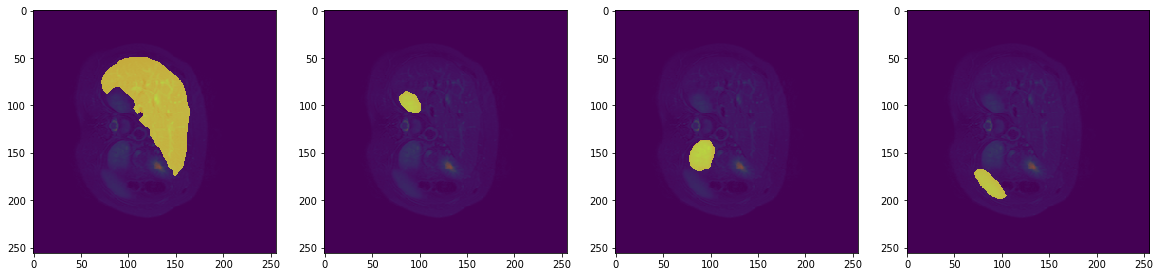

In [41]:
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(1,4,i+1)
    slice_ = imgs_mask_train[id,:,:,i]
    plt.imshow(imgs_train[id,:,:,0])
    plt.imshow(slice_, alpha=0.7)    
plt.show()

7.757402e-07 0.99999094
9.002792e-06 0.99062574
2.4310332e-10 0.6136961
1.4017776e-10 0.6425721


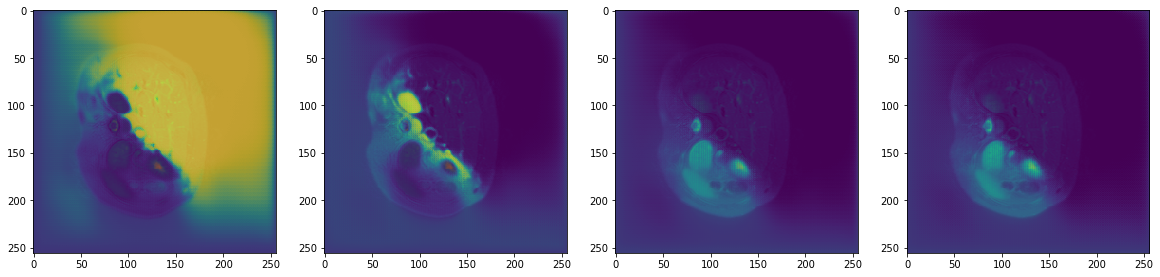

In [43]:
plt.figure(figsize=(20, 15))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(imgs_train[id,:,:,0])
    slice_ = y_pred[0,:,:,i]
    x = np.sum(y_pred, axis = 3)[0]
    print(slice_.min(), slice_.max())
    m = slice_.mean()
    plt.imshow(slice_,vmin=0,vmax=1, alpha=0.7)
plt.show()